In [ ]:
pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from glob import glob
from matplotlib import pyplot
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools
import sklearn
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from tensorflow.keras.utils import to_categorical  # Correct import for to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator  # Correct import for ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
''' Data Path '''
train_path = '/content/drive/MyDrive/Braintumor_new/Braintumor_new'

In [ ]:
File=[]
for f in os.listdir(train_path):
    File += [f]

'''  total number of classes '''
print(File)

['yes', 'no']


In [ ]:
''' reading images '''

train_data = []

''' label encoding '''
mapping={'yes':1, 'no':0}

count=0

for f in os.listdir(train_path):
    ''' joining path '''
    path = os.path.join(train_path, f)
    for im in os.listdir(path):
        ''' loading an image '''
        img = load_img(os.path.join(path, im), color_mode='rgb', target_size=(128,128))
        ''' converting an image to array '''
        img = img_to_array(img)
        ''' scaling  '''
        img = img / 255.0
        ''' appending image to train_data '''
        train_data.append([img, count])
    count=count+1

In [ ]:
train_images, train_labels = zip(*train_data)

In [ ]:
''' converting labels into to_categorical '''
train_labels = to_categorical(train_labels)

''' coverting train_images into numpy array '''
train_images = np.array(train_images)

''' converting train_labesl into numpy array '''
train_labels = np.array(train_labels)

''' shaep of train_images and train_labels '''
print(train_images.shape)
print(train_labels.shape)

(253, 128, 128, 3)
(253, 2)


In [ ]:
''' reshaping images '''
train_images = train_images.reshape(-1,128,128,3)

In [ ]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(train_images,train_labels, test_size=0.1,random_state=44)

In [ ]:
''' shape of X_train, X_test, y_train, y_test '''
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227, 128, 128, 3)
(26, 128, 128, 3)
(227, 2)
(26, 2)


In [ ]:
''' data Augmentation '''
data_aug = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2,
                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1, fill_mode="nearest")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Input, Concatenate
from tensorflow.keras.models import Model

# Input layer
inp = Input(shape=(128, 128, 3))

# ===== DenseNet121 branch =====
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=inp, pooling='avg')
densenet_base.trainable = False  # freeze DenseNet for transfer learning

# ===== Custom CNN branch =====
x = Conv2D(32, (3,3), activation='relu')(inp)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)

# ===== Merge branches =====
merged = Concatenate()([densenet_base.output, x])

# ===== Fully connected head =====
fc = Dense(128, activation='relu')(merged)
out = Dense(2, activation='softmax')(fc)  # 2 classes — change as needed

# ===== Final model =====
model = Model(inputs=inp, outputs=out)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,278,594 (27.77 MB)

 Trainable params: 241,090 (941.76 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Train your model
history = model.fit(data_aug.flow(X_train, y_train, batch_size=8),
                    validation_data=(X_test, y_test),
                    epochs=10)

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)   # predicted labels
y_true = np.argmax(y_test, axis=1)         # true labels

# Classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5621 - loss: 1.2389 - val_accuracy: 0.7692 - val_loss: 0.3524
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step - accuracy: 0.8238 - loss: 0.4209 - val_accuracy: 0.9615 - val_loss: 0.1585
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 595ms/step - accuracy: 0.8093 - loss: 0.4319 - val_accuracy: 0.8077 - val_loss: 0.5928
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 662ms/step - accuracy: 0.7604 - loss: 0.5656 - val_accuracy: 0.9231 - val_loss: 0.2073
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step - accuracy: 0.8566 - loss: 0.3209 - val_accuracy: 0.9231 - val_loss: 0.1606
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.8338 - loss: 0.2925 - val_accuracy: 1.0000 - val_loss: 0.1070
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 642ms/step - accuracy: 0.9017 - loss: 0.2322 - val_accuracy: 0.8846 - val_loss: 0.1549
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step - accuracy: 0.8925 - loss: 0.2314 - val_accuracy: 1.0000 -

In [ ]:
''' training '''
history=model.fit(data_aug.flow(X_train, y_train, batch_size=8), validation_data=(X_test, y_test), epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 703ms/step - accuracy: 0.8838 - loss: 0.2276 - val_accuracy: 0.9615 - val_loss: 0.1227
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 595ms/step - accuracy: 0.9135 - loss: 0.1922 - val_accuracy: 0.9231 - val_loss: 0.2024
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 651ms/step - accuracy: 0.8789 - loss: 0.3046 - val_accuracy: 0.9615 - val_loss: 0.1277
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 632ms/step - accuracy: 0.9158 - loss: 0.2251 - val_accuracy: 0.9231 - val_loss: 0.1532
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 623ms/step - accuracy: 0.8856 - loss: 0.2231 - val_accuracy: 1.0000 - val_loss: 0.0871
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 669ms/step - accuracy: 0.9335 - loss: 0.1663 - val_accuracy: 0.9231 - val_loss: 0.1596
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 678ms/step - accuracy: 0.9273 - loss: 0.1840 - val_accuracy: 0.9231 - val_loss: 0.1317
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 598ms/step - accuracy: 0.9482 - loss: 0.1545 - val_accuracy: 0.923

In [ ]:
''' prediction '''
y_pred=model.predict(X_test)

''' retreiving max val from predicted values '''
pred = np.argmax(y_pred,axis=1)

''' retreiving max val from actual values '''
ground = np.argmax(y_test,axis=1)

from sklearn.metrics import classification_report

''' classificaion report '''
print(classification_report(ground,pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.88      0.93         8

    accuracy                           0.96        26
   macro avg       0.97      0.94      0.95        26
weighted avg       0.96      0.96      0.96        26



In [ ]:
# Viewing Model Summary
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,760,776 (29.61 MB)

 Trainable params: 241,090 (941.76 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 482,182 (1.84 MB)

None


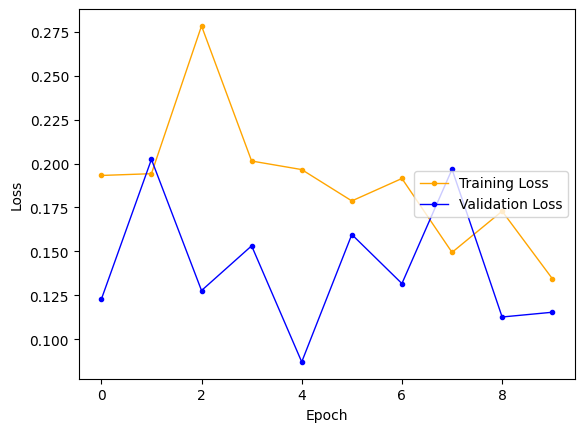

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
''' training loss and validation loss graph '''
epochs = range(10)
plt.plot(epochs, history.history['loss'], 'orange', marker=".",  label='Training Loss', linewidth=1)
plt.plot(epochs, history.history['val_loss'], 'b', marker=".", label='Validation Loss', linewidth=1)
#plt.title('Training vs validation loss')
plt.xlabel('Epoch'); plt.ylabel('Loss');
plt.legend(loc=5)
plt.figure()
plt.show()
pyplot.savefig("Loss.tiff",format="tiff")


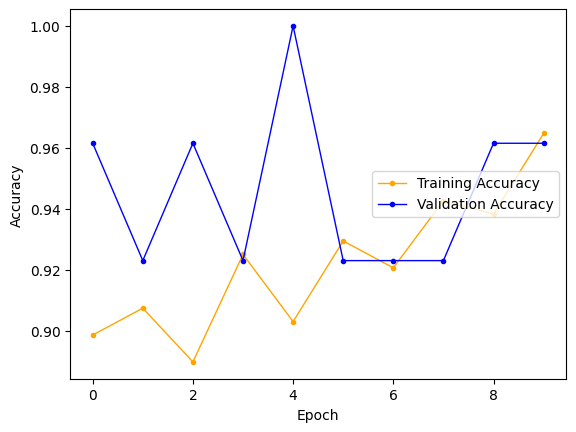

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
''' training accuracy and validation accuracy graph '''
epochs = range(10)
plt.plot(epochs, history.history['accuracy'], 'orange', marker=".", label='Training Accuracy', linewidth=1)
plt.plot(epochs, history.history['val_accuracy'], 'b', marker=".", label='Validation Accuracy', linewidth=1)
#plt.title('Training vs validation accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy');
plt.legend(loc=5)
plt.figure()
plt.show()
pyplot.savefig("ACC.tiff",format="tiff")


In [ ]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
''' checking accuracy score'''
accuracy = accuracy_score(y_test_arg, Y_pred)
print(accuracy)

0.9615384615384616


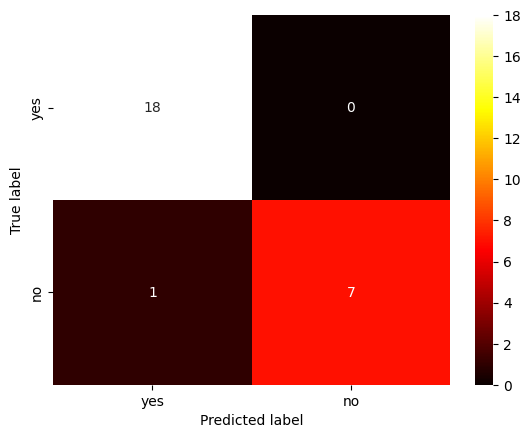

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_arg, Y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap="hot")
# labels, title and ticks
f.set_xlabel('Predicted label');f.set_ylabel('True label');
#f.set_title('Confusion Matrix');
f.xaxis.set_ticklabels(['yes', 'no']); f.yaxis.set_ticklabels(['yes','no']);
pyplot.savefig("CM.tiff",format="tiff")

In [ ]:
# Evaluating Metrices

TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: 7
True Negatives: 18
False Positives: 0
False Negatives: 1


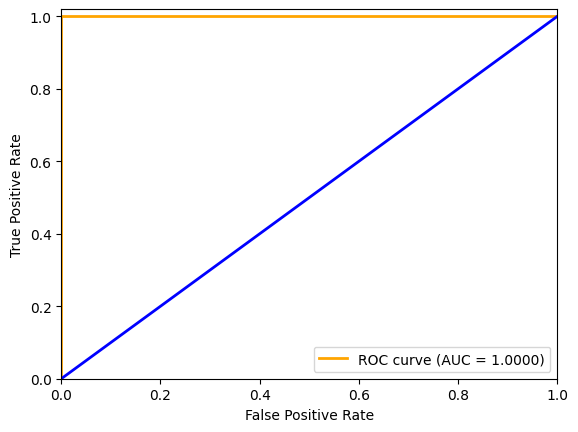

--------------------------------------------------
Accuracy: 0.9615
Mis-Classification: 0.0385
Sensitivity: 0.875
Specificity: 1.0
Precision: 1.0
NPV: 0.9474
f_1 Score: 1.87


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate accuracy
conf_accuracy = (float(TP + TN) / float(TP + TN + FP + FN))

# Calculate mis-classification
conf_misclassification = 1 - conf_accuracy

# Calculate sensitivity
conf_sensitivity = (TP / float(TP + FN))

# Calculate specificity
conf_specificity = (TN / float(TN + FP))

# Calculate precision
conf_precision = (TN / float(TN + FP))

# Calculate NPV
conf_NPV = (TN / float(TN + FN))

# Calculate f_1 score
conf_f1 = 4 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))

# Calculate predicted probabilities
y_scores = model.predict_on_batch(X_test)[:, 1]  # Assuming you have a model and input data (X) available

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_arg, y_scores)  # Replace y_true with your true labels

# Calculate AUC score
auc = roc_auc_score(y_test_arg, y_scores)  # Replace y_true with your true labels

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, 'orange',  label='ROC curve (AUC = %0.4f)' % auc, linewidth=2)
plt.plot([0, 1], [0, 1], 'b', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print('-' * 50)
print(f'Accuracy: {round(conf_accuracy, 4)}')
print(f'Mis-Classification: {round(conf_misclassification, 4)}')
print(f'Sensitivity: {round(conf_sensitivity, 4)}')
print(f'Specificity: {round(conf_specificity, 4)}')
print(f'Precision: {round(conf_precision, 4)}')
print(f'NPV: {round(conf_NPV, 4)}')
print(f'f_1 Score: {round(conf_f1, 2)}')